# Install (important)

In [1]:
# Install the latest version of author's repo neural ode implementation
!git clone https://github.com/rtqichen/torchdiffeq.git
!cd torchdiffeq && pip install -e .
!ls torchdiffeq/torchdiffeq

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 1121, done.
remote: Counting objects: 100% (417/417), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1121 (delta 247), reused 398 (delta 238), pack-reused 704
Receiving objects: 100% (1121/1121), 8.29 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (673/673), done.
Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq
_impl  __init__.py


# LatentODE on residuals

d1d2d3d4d5d6d7 as input, m1m2m3m4m5m6m7m8m9m10 as output

## ExxonMobil: Trial 1

In [47]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(len(array), 1)  #, keepdims=True)

def get_residuals(data):
    c5 = data[:-1, -1].reshape((data_size-1, 1))
    residual_data = data[1:] - c5
    return residual_data

def get_scalar(data):
    # https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    return scaler, data_scaled

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.Tanh()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.Tanh()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data


In [79]:
# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/data-2000-2021/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')

print('Get Residuals')
residual_data = get_residuals(data)
print(pd.DataFrame(residual_data))
print('\n')

print('We do not need the first row')
data = data[1:]
print(data.shape)
print(pd.DataFrame(data))
print('\n')

lag = 4
forecast = 2
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')

print('Scale the data_orig')
scaler_data_orig, data_orig_scaled = get_scalar(data_orig)
print(f"data_orig_scaled.shape : {data_orig_scaled.shape}")
print(pd.DataFrame(data_orig_scaled))
print('\n')

# median data will be on residual data
median_data = get_median(residual_data)
print('Median of residual data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_residual_week']).head(10))
print('\n')

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median residual data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')

print('Scale the data_ml')
scaler_data_ml, data_m1_scaled = get_scalar(data_m1)
print(f"data_m1_scaled.shape : {data_m1_scaled.shape}")
print(pd.DataFrame(data_m1_scaled))
print('\n')

dataload = split_data(0.9, 0, lag, data_orig_scaled, data_m1_scaled, data.shape[1], 1)

print('Get Train and Test data')
train_X = torch.from_numpy(dataload['train_X']).to(device)
print(f"train_X shape: {train_X.shape}")  # (#training, 1, 5)

train_y = torch.from_numpy(dataload['train_y']).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 5)
train_y = torch.reshape(train_y, (train_X.shape[0], 1, train_y.shape[1])).to(device)
print(f"train_y shape: {train_y.shape}")  # (#training, 1, 5)
test_X = torch.from_numpy(dataload['test_X']).to(device)
print(f"test_X.shape : {test_X.shape}")  # (#testing, 1, 5)
test_y = torch.from_numpy(dataload['test_y']).to(device)
print(f"test_y.shape : {test_y.shape}")  # (#testing, 5)
test_y = torch.reshape(test_y, (test_X.shape[0], 1, test_y.shape[1])).to(device)
print(f"test_y.shape : {test_y.shape}")

train_y_recon = torch.from_numpy(dataload['train_y_recon']).to(device)
train_y_recon = torch.reshape(train_y_recon, (train_y_recon.shape[0], 1,train_y_recon.shape[1]))
train_y_extrapol = torch.from_numpy(dataload['train_y_extrapol']).to(device)
train_y_extrapol = torch.reshape(train_y_extrapol, (train_y_extrapol.shape[0], 1, train_y_extrapol.shape[1]))
test_y_recon = torch.from_numpy(dataload['test_y_recon']).to(device)
test_y_recon = torch.reshape(test_y_recon, (test_y_recon.shape[0], 1, test_y_recon.shape[1]))
test_y_extrapol = torch.from_numpy(dataload['test_y_extrapol']).to(device)
test_y_extrapol = torch.reshape(test_y_extrapol, (test_y_extrapol.shape[0], 1, test_y_extrapol.shape[1]))
print(f"train_y_recon.shape : {train_y_recon.shape}")
print(f"train_y_extrapol.shape : {train_y_extrapol.shape}")
print(f"test_y_recon.shape : {test_y_recon.shape}")
print(f"test_y_extrapol.shape : {test_y_extrapol.shape}")
print('\n')

trial = 1
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0, lag+forecast-1, lag+forecast).to(device)
print(f"t.shape : {t.shape}")

latent_dim = 50
nhidden = 100
rnn_nhidden = 125
obs_dim = data.shape[1]
out_dim = 1
noise_std = .3

lr = 0.001
loss_str = 'elbo'
# all_values = True
niters = 125  # training epochs

Data after Data Transformation
              0          1          2  ...          7          8          9
0     20.462499  20.156849  19.915541  ...  21.926409  22.119449  21.862059
1     21.669014  21.556406  21.556412  ...  21.990755  22.006838  21.556406
2     21.299012  21.813791  21.685104  ...  21.878151  21.990747  21.685097
3     21.620746  21.636833  21.636842  ...  20.301626  20.237288  21.331196
4     21.443802  21.411629  21.427711  ...  20.816418  20.462498  20.784235
...         ...        ...        ...  ...        ...        ...        ...
1085  57.145067  56.967754  57.135219  ...  56.711628  56.691926  56.721481
1086  56.711630  57.332237  56.337292  ...  56.997307  56.278189  56.347145
1087  56.563864  57.312534  57.322381  ...  56.770000  56.020000  55.939999
1088  55.500000  55.560001  55.419998  ...  52.740002  53.950001  54.910000
1089  55.290001  55.360001  55.240002  ...  55.770000  56.240002  55.160000

[1090 rows x 10 columns]


Get Residuals
             0 

In [80]:
## Training
# model
nbatches_train = train_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_list = train(loss_str, niters)

# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html
torch.save(func.state_dict(), f"model-latentode/{tickerName}-trial{trial}-func-residuals.pth")
torch.save(rec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-rec-residuals.pth")
torch.save(dec.state_dict(), f"model-latentode/{tickerName}-trial{trial}-dec-residuals.pth")

func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_train).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-residuals.pth"))  # f"model-latentode/{tickerName}-trial{trial}-func-moresequences.pth"
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-residuals.pth"))  # f"model-latentode/{tickerName}-trial{trial}-rec-moresequences.pth"
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-residuals.pth"))  # f"model-latentode/{tickerName}-trial{trial}-dec-moresequences.pth"

h = rec.initHidden().to(device)
pred_train, pred_train_recon, pred_train_extrapol = train_loss(h)

# Testing
# model

nbatches_test = test_X.shape[0]
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nbatches_test).to(device)
dec = Decoder(latent_dim, out_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))

func.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-func-residuals.pth"))
rec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-rec-residuals.pth"))
dec.load_state_dict(torch.load(f"model-latentode/{tickerName}-trial{trial}-dec-residuals.pth")) 

h = rec.initHidden().to(device)
pred_test, pred_test_recon, pred_test_extrapol = test_loss(h, t)


Iter: 10, running: -0.2119
Iter: 20, running: -0.6273
Iter: 30, running: -0.8055
Iter: 40, running: -0.8949
Iter: 50, running: -0.9097
Iter: 60, running: -0.9341
Iter: 70, running: -0.9456
Iter: 80, running: -0.9613
Iter: 90, running: -0.9519
Iter: 100, running: -0.9558
Iter: 110, running: -0.9574
Iter: 120, running: -0.9683
Train: Reconstruction Loss
Total Train Loss 0.150059
Train: Extrapolation Loss
Total Train Extrapolation Loss 0.148994
Test: Reconstruction Loss
Total Loss 0.267704
Test: Extrapolation Loss
Total Loss 0.268391


In [81]:
with torch.no_grad():
    print(scaler_data_ml.inverse_transform(pred_test[:, 0, :].cpu().numpy()).shape)

(109, 6)


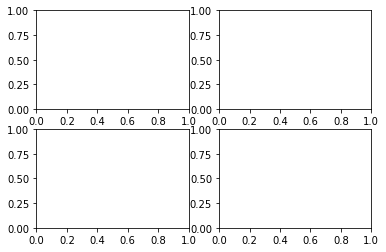

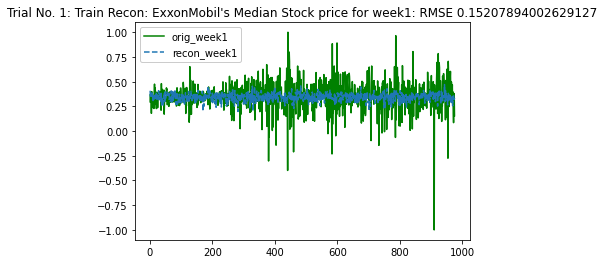

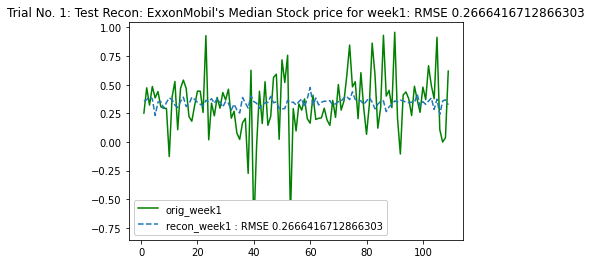

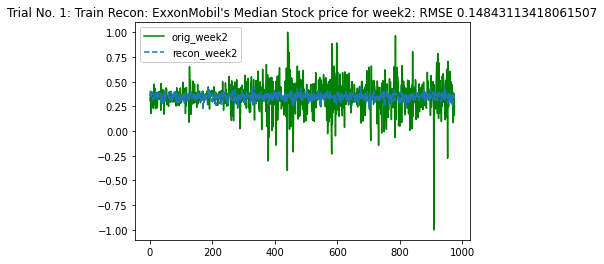

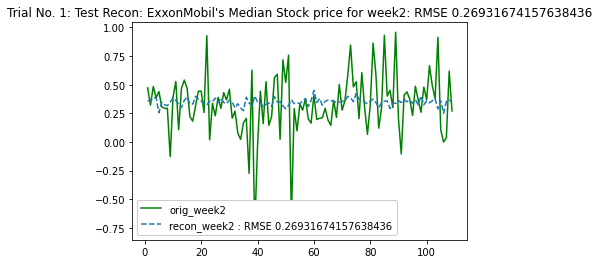

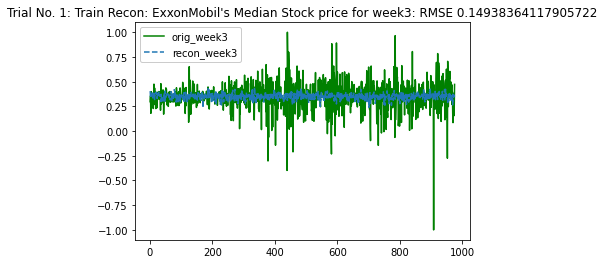

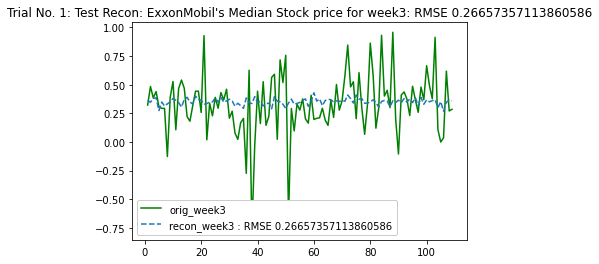

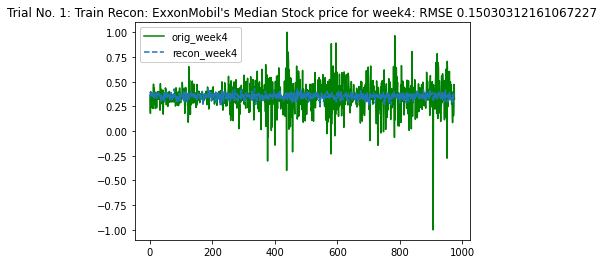

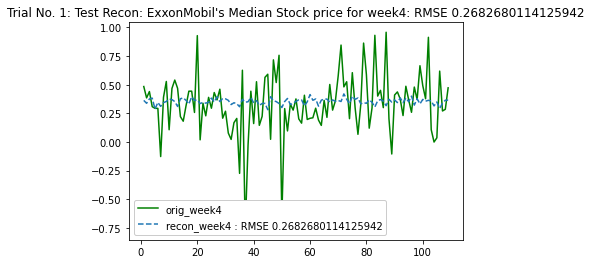

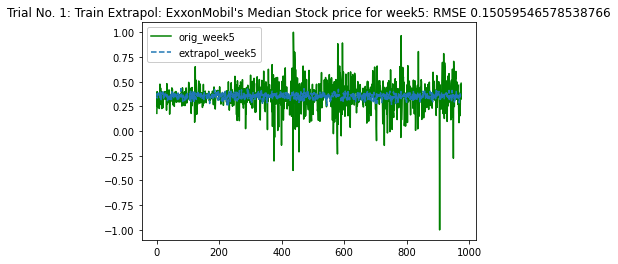

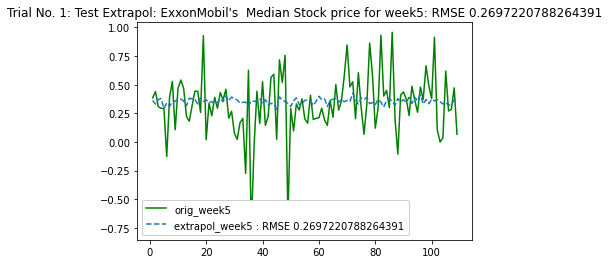

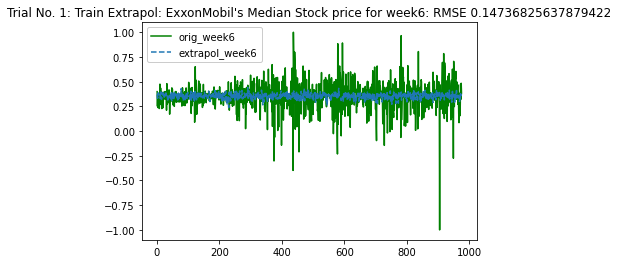

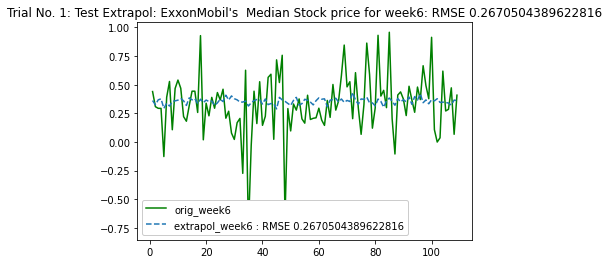

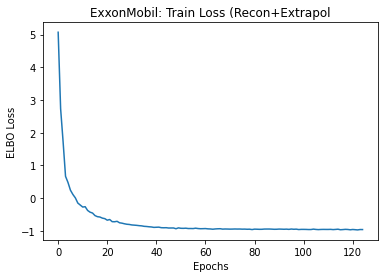

In [82]:
# Plots
fig, axes = plt.subplots(2, 2)
for i in range(1, lag+forecast+1):
    if i<=lag:
        plot_train_recon(i, train_y_recon, pred_train_recon, fig, axes)
        plot_test_recon(i, test_y_recon, pred_test_recon, fig, axes)
    elif i>lag:
        plot_train_extrapol(i, train_y_extrapol, pred_train_extrapol, fig, axes)
        plot_test_extrapol(i, test_y_extrapol, pred_test_extrapol, fig, axes)
plot_loss(loss_list)

In [83]:
# RMSE Table
recon_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-recon-rmse-residuals.csv"
extrapol_rmse_filepath = f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse-residuals.csv"
recon_rmse_data, extrapol_rmse_data = rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol)

pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-recon-rmse-residuals.csv", index_col=0)

,week,train_recon_rmse,test_recon_rmse
0,1,0.152079,0.266642
1,2,0.148431,0.269317
2,3,0.149384,0.266574
3,4,0.150303,0.268268


In [84]:
pd.read_csv(f"results-latentode/{tickerName}-trial{trial}-extrapol-rmse-residuals.csv", index_col=0)

,week,train_extrapol_rmse,test_extrapol_rmse
0,5,0.150595,0.269722
1,6,0.147368,0.267050


# Rough

In [29]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(len(array), 1)  #, keepdims=True)

def get_residuals(data):
    c5 = data[:-1, -1].reshape((data_size-1, 1))
    residual_data = data[1:] - c5
    return residual_data

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x).to(device)
        out = self.elu(out).to(device)
        out = self.fc2(out).to(device)
        out = self.elu(out).to(device)
        out = self.fc3(out).to(device)
        return out

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        h = torch.tanh(self.i2h(combined.float())).to(device)
        out = self.h2o(h).to(device)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z).to(device)
        out = self.relu(out).to(device)
        out = self.fc2(out).to(device)
        return out

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device).to(device)
    const = torch.log(const).to(device)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl.to(device)

def train(loss_str, niters):
    loss_list = []
    for itr in range(1, niters + 1):
    
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (# nbatches_train, rnn_hidden)
        for t_r in reversed(range(train_X.shape[2])):  # input_dimension
            obs = train_X[:, :, t_r].to(device)
            # obs = torch.reshape(obs, (1, 1)).to(device)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)  # [:, -1, :]
        pred_x = dec(pred_z).to(device)
        pred_x = torch.reshape(pred_x, (train_X.shape[0], lag+forecast)).to(device)

        # compute loss
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_x.float(), train_X[i, :, :].float().to(device)).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_y[:, 0, :].to(device), pred_x, noise_logvar).sum(-1)  # .sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0).to(device)
            # loss = torch.reshape(loss, (1, 1)).to(device)
        loss_list.append(loss)
            # loss_ = torch.mean(torch.cat([x.float() for x in loss_list])).to(device)  
        loss.backward()
        optimizer.step()
        # loss_meter.update(loss.item())
        if itr%10==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))
    return loss_list

def train_loss(h):
    train_loss = 0.0
    predictions = []
    
    for t_r in reversed(range(train_X.shape[2])):
        obs = train_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)

    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t.to(device)).permute(1, 0, 2)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[:, :, :].to(device))
    loss_recon = rmse(pred_x_recon, train_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, train_y_extrapol)
    # train_loss += loss
    # predictions.append(pred_x)
    
    # train_loss = torch.sqrt(train_loss)
    # train_pred = torch.cat([x.float() for x in predictions])
    # train_pred = torch.reshape(train_pred, (train_pred.shape[0], 1, lag))
    with torch.no_grad():
        print('Train: Reconstruction Loss')
        print('Total Train Loss {:.6f}'.format(loss_recon.item()))
        print('Train: Extrapolation Loss')
        print('Total Train Extrapolation Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def test_loss(h, t_test):
    # print(h.shape)
    test_loss = 0.0
    predictions = []
    rmse = RMSELoss()
    for t_r in reversed(range(test_X.shape[2])):
        obs = test_X[:, :, t_r].to(device)
        # obs = torch.reshape(obs, (1, 1)).to(device)
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim].to(device), out[:, latent_dim:].to(device)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, t_test).permute(1, 0, 2).to(device)
    pred_x = dec(pred_z).to(device)
    pred_x = torch.reshape(pred_x, (pred_x.shape[0], 1, lag+forecast))
    pred_x_recon = pred_x[:, :, :lag]
    pred_x_extrapol = pred_x[:, :, lag:]
    # pred_test_X = torch.reshape(pred_test_X, (pred_test_X.shape[0], pred_test_X.shape[1]))
    # pred_test_y = torch.reshape(pred_test_y, (1, pred_test_y.shape[0], 1, lag))
    # print(test_pred_y.shape)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(pred_x, train_X[i, :, :].to(device))
    loss_recon = rmse(pred_x_recon, test_y_recon)
    loss_extrapol = rmse(pred_x_extrapol, test_y_extrapol)

    # loss = torch.nn.MSELoss()(pred_x, torch.reshape(test_X[i, :, :].to(device), (1, 5))).to(device)
    # test_loss += loss
    # predictions.append(pred_x)
    
    # test_loss = torch.sqrt(test_loss)
    # test_pred = torch.cat([x.float() for x in predictions])
    
    # loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Test: Reconstruction Loss')
        print('Total Loss {:.6f}'.format(loss_recon.item()))
        print('Test: Extrapolation Loss')
        print('Total Loss {:.6f}'.format(loss_extrapol.item()))
    return pred_x, pred_x_recon, pred_x_extrapol

def plot_train_recon(i, train_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., train_y_recon.shape[0], train_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i}")
    plt.title(f"Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_train_extrapol(i, train_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., train_y_extrapol.shape[0], train_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), train_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i}")
    plt.title(f"Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Train Extrapol: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_recon(i, test_y_recon, pred_y_recon, fig, axes):
    t_ = torch.linspace(1., test_y_recon.shape[0], test_y_recon.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_recon.cpu().numpy()[:, :, i-1], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_y_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_recon.cpu().numpy()[:, :, i-1], '--', label = f"recon_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Recon: {tickerName}'s Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_test_extrapol(i, test_y_extrapol, pred_y_extrapol, fig, axes):
    t_ = torch.linspace(1., test_y_extrapol.shape[0], test_y_extrapol.shape[0])
    plt.figure()
    plt.plot(t_.numpy(), test_y_extrapol.cpu().numpy()[:, :, i-1-lag], 'g', label = f"orig_week{i}")
    with torch.no_grad():
        rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_y_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
        plt.plot(t_.numpy(), pred_y_extrapol.cpu().numpy()[:, :, i-1-lag], '--', label = f"extrapol_week{i} : RMSE {rmse}")
    plt.title(f"Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}: RMSE {rmse}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-latentode/Trial No. {trial}: Test Extrapol: {tickerName}'s  Median Stock price for week{i}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title(f'{tickerName}: Train Loss (Recon+Extrapol')
    plt.ylabel('ELBO Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-latentode/{tickerName}: Trial No. {trial}: ELBO Train Loss.pdf", dpi = 150)
    plt.show()

def rmse_table(recon_rmse_filepath, extrapol_rmse_filepath, train_y_recon, pred_train_recon, train_y_extrapol, pred_train_extrapol, test_y_recon, pred_test_recon, test_y_extrapol, pred_test_extrapol):
    recon_rmse_data = {
        'week': list(),
        'train_recon_rmse': list(),
        'test_recon_rmse': list()
    }

    extrapol_rmse_data = {
        'week': list(),
        'train_extrapol_rmse': list(),
        'test_extrapol_rmse': list()
    }
    for i in range(1, lag+forecast+1):
        with torch.no_grad():
            if i<=lag:
                recon_rmse_data['week'].append(i)
                train_recon_rmse = np.sqrt(((train_y_recon.cpu().numpy()[:, :, i-1] - pred_train_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['train_recon_rmse'].append(train_recon_rmse)
                test_recon_rmse = np.sqrt(((test_y_recon.cpu().numpy()[:, :, i-1] - pred_test_recon.cpu().numpy()[:, :, i-1]) ** 2).mean())
                recon_rmse_data['test_recon_rmse'].append(test_recon_rmse)
            elif i>lag:
                extrapol_rmse_data['week'].append(i)
                train_extrapol_rmse = np.sqrt(((train_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_train_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['train_extrapol_rmse'].append(train_extrapol_rmse)
                test_extrapol_rmse = np.sqrt(((test_y_extrapol.cpu().numpy()[:, :, i-1-lag] - pred_test_extrapol.cpu().numpy()[:, :, i-1-lag]) ** 2).mean())
                extrapol_rmse_data['test_extrapol_rmse'].append(test_extrapol_rmse)
    recon_rmse_df = pd.DataFrame(recon_rmse_data)
    recon_rmse_df.to_csv(recon_rmse_filepath)
    extrapol_rmse_df = pd.DataFrame(extrapol_rmse_data)
    extrapol_rmse_df.to_csv(extrapol_rmse_filepath)

    return recon_rmse_data, extrapol_rmse_data


In [30]:
# FileName
tickerName = 'ExxonMobil'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
print('Data after Data Transformation')
# # Total Data Size
data_size = data.shape[0]

print(pd.DataFrame(data))
print('\n')


Data after Data Transformation
              0          1          2  ...          7          8          9
0      0.178288   0.179010   0.179010  ...   0.180453   0.180453   0.180814
1      0.180814   0.181536   0.181536  ...   0.179731   0.179731   0.177927
2      0.177927   0.178649   0.178649  ...   0.177566   0.177566   0.176483
3      0.176483   0.173957   0.173957  ...   0.167821   0.166378   0.164212
4      0.163852   0.162769   0.162769  ...   0.164573   0.164573   0.164212
...         ...        ...        ...  ...        ...        ...        ...
2549  41.166637  40.800957  40.508416  ...  38.853703  39.447934  40.819241
2550  40.362144  39.868473  39.676488  ...  40.289005  40.142736  39.813622
2551  39.959889  40.252434  39.429652  ...  38.625149  38.707430  39.740482
2552  40.362140  40.087875  39.676486  ...  40.691257  41.596317  41.111790
2553  41.447394  41.102467  40.552445  ...  39.750713  39.704109  39.554951

[2554 rows x 10 columns]




In [31]:
data[:-1, -1].shape

(2553,)

In [32]:
pd.DataFrame(data[1:] - data[:-1, -1].reshape((2553, 1)))

,0,1,2,3,4,5,6,7,8,9
0,-1.633554e-07,0.000722,0.000722,-0.000722,-0.000722,-0.001444,-1.443646e-03,-0.001083,-0.001083,-0.002887
1,2.975615e-08,0.000722,0.000722,0.000722,0.000722,0.000000,-5.164857e-08,-0.000361,-0.000361,-0.001444
2,5.464962e-08,-0.002526,-0.002526,-0.002165,-0.002887,-0.003248,-3.248055e-03,-0.008662,-0.010105,-0.012271
3,-3.608387e-04,-0.001444,-0.001444,-0.002526,-0.002526,0.000722,7.218651e-04,0.000361,0.000361,0.000000
4,-2.165352e-03,-0.003970,-0.003970,-0.004692,-0.005414,-0.010466,-1.046623e-02,-0.009384,-0.009744,-0.013353
...,...,...,...,...,...,...,...,...,...,...
2548,8.776312e-01,0.511951,0.219411,0.191982,0.237692,-0.502815,-7.862182e-01,-1.435303,-0.841072,0.530235
2549,-4.570961e-01,-0.950768,-1.142753,-0.868492,-0.703933,-1.115326,-1.298167e+00,-0.530235,-0.676505,-1.005619
2550,1.462670e-01,0.438812,-0.383970,-1.535870,-2.184950,-1.343880,-1.371314e+00,-1.188473,-1.106192,-0.073139
2551,6.216572e-01,0.347393,-0.063996,0.155411,-0.219414,-0.027431,4.753917e-01,0.950775,1.855835,1.371307


In [33]:
print('Get Residuals')
residual_data = get_residuals(data)
print(pd.DataFrame(residual_data))
print('\n')

Get Residuals
                 0         1         2  ...         7         8         9
0    -1.633554e-07  0.000722  0.000722  ... -0.001083 -0.001083 -0.002887
1     2.975615e-08  0.000722  0.000722  ... -0.000361 -0.000361 -0.001444
2     5.464962e-08 -0.002526 -0.002526  ... -0.008662 -0.010105 -0.012271
3    -3.608387e-04 -0.001444 -0.001444  ...  0.000361  0.000361  0.000000
4    -2.165352e-03 -0.003970 -0.003970  ... -0.009384 -0.009744 -0.013353
...            ...       ...       ...  ...       ...       ...       ...
2548  8.776312e-01  0.511951  0.219411  ... -1.435303 -0.841072  0.530235
2549 -4.570961e-01 -0.950768 -1.142753  ... -0.530235 -0.676505 -1.005619
2550  1.462670e-01  0.438812 -0.383970  ... -1.188473 -1.106192 -0.073139
2551  6.216572e-01  0.347393 -0.063996  ...  0.950775  1.855835  1.371307
2552  3.356047e-01 -0.009323 -0.559345  ... -1.361076 -1.407681 -1.556839

[2553 rows x 10 columns]




In [34]:
print('We do not need the first row')
data = data[1:]
print(data.shape)
print(pd.DataFrame(data))
print('\n')

We do not need the first row
(2553, 10)
              0          1          2  ...          7          8          9
0      0.180814   0.181536   0.181536  ...   0.179731   0.179731   0.177927
1      0.177927   0.178649   0.178649  ...   0.177566   0.177566   0.176483
2      0.176483   0.173957   0.173957  ...   0.167821   0.166378   0.164212
3      0.163852   0.162769   0.162769  ...   0.164573   0.164573   0.164212
4      0.162047   0.160242   0.160242  ...   0.154829   0.154468   0.150859
...         ...        ...        ...  ...        ...        ...        ...
2548  41.166637  40.800957  40.508416  ...  38.853703  39.447934  40.819241
2549  40.362144  39.868473  39.676488  ...  40.289005  40.142736  39.813622
2550  39.959889  40.252434  39.429652  ...  38.625149  38.707430  39.740482
2551  40.362140  40.087875  39.676486  ...  40.691257  41.596317  41.111790
2552  41.447394  41.102467  40.552445  ...  39.750713  39.704109  39.554951

[2553 rows x 10 columns]




In [35]:
lag = 7
forecast = 3
data_orig = series_to_supervised(data, lag, forecast).values
print('Data Original after series to supervised on data')
print(data_orig.shape)
print(pd.DataFrame(data_orig))
print('\n')


Data Original after series to supervised on data
(2544, 100)
             0          1          2   ...         97         98         99
0      0.180814   0.181536   0.181536  ...   0.158799   0.158799   0.159521
1      0.177927   0.178649   0.178649  ...   0.165656   0.165656   0.166739
2      0.176483   0.173957   0.173957  ...   0.166739   0.166378   0.165656
3      0.163852   0.162769   0.162769  ...   0.161686   0.161686   0.161325
4      0.162047   0.160242   0.160242  ...   0.156272   0.155912   0.155190
...         ...        ...        ...  ...        ...        ...        ...
2539  41.352184  41.020363  41.523178  ...  38.853703  39.447934  40.819241
2540  40.590692  41.450043  41.642029  ...  40.289005  40.142736  39.813622
2541  41.815729  41.971142  42.656795  ...  38.625149  38.707430  39.740482
2542  42.839633  43.251026  43.881827  ...  40.691257  41.596317  41.111790
2543  48.343151  48.928242  48.909956  ...  39.750713  39.704109  39.554951

[2544 rows x 100 columns]


In [36]:
# median data will be on residual data
median_data = get_median(residual_data)
print('Median of residual data')
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_residual_week']).head(10))
print('\n')

Median of residual data
(2553, 1)
   median_residual_week
0         -9.022579e-04
1          1.487808e-08
2         -3.067564e-03
3         -1.804194e-04
4         -7.398589e-03
5         -2.526443e-03
6          3.609175e-03
7         -1.443535e-03
8          2.887196e-03
9          5.413856e-04




In [37]:
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print('Median residual data after series to supervised')
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
print('\n')


Median residual data after series to supervised
(2544, 10)
          week i+1      week i+2  week i+3  ...  week i+8  week i+9  week i+10
0    -9.022579e-04  1.487808e-08 -0.003068  ... -0.001444  0.002887   0.000541
1     1.487808e-08 -3.067564e-03 -0.000180  ...  0.002887  0.000541   0.004150
2    -3.067564e-03 -1.804194e-04 -0.007399  ...  0.000541  0.004150  -0.000722
3    -1.804194e-04 -7.398589e-03 -0.002526  ...  0.004150 -0.000722  -0.003248
4    -7.398589e-03 -2.526443e-03  0.003609  ... -0.000722 -0.003248  -0.000902
...            ...           ...       ...  ...       ...       ...        ...
2539 -2.049312e+00  2.386072e+00  1.119902  ... -0.077702 -0.420532   0.205697
2540  2.386072e+00  1.119902e+00  2.642056  ... -0.420532  0.205697  -0.909630
2541  1.119902e+00  2.642056e+00 -6.358294  ...  0.205697 -0.909630  -1.147332
2542  2.642056e+00 -6.358294e+00 -0.333685  ... -0.909630 -1.147332   0.411392
2543 -6.358294e+00 -3.336849e-01 -1.581568  ... -1.147332  0.411392  -0.

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_scalar(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    return scaler, data_scaled

In [45]:
MinMaxScaler(feature_range=(-1, 1)).fit_transform(data_orig).shape

(2544, 100)